## Installation des packages

Les packages Python sont installés automatiquement à partir du fichier `requirements.txt`

In [3]:
# download requirement
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Téléchargement des données à partir de Kaggle

On télécharge les données grâce à l'API Kaggle de Python

In [4]:
# download dataset zip from Kaggle
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

# unzip data into data folder
!unzip stanford-car-dataset-by-classes-folder.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
100%|█████████████████████████████████████▉| 1.82G/1.83G [00:48<00:00, 43.4MB/s]
100%|██████████████████████████████████████| 1.83G/1.83G [00:48<00:00, 40.5MB/s]
Archive:  stanford-car-dataset-by-classes-folder.zip
  inflating: data/anno_test.csv      
  inflating: data/anno_train.csv     
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/00076.jpg  
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/00457.jpg  
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/00684.jpg  
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/01117.jpg  
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/01167.jpg  
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/01199.jpg  
  inflating: data/car_data/car_data/test/AM General Hummer SUV 2000/01226.jpg  
  inflating: data/car_data/car_data/tes

## Chargement des fichiers csv

In [2]:
import os
import pandas as pd
import s3fs
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def read_csv_file(filename, cols):
    df = pd.read_csv(f'data/{filename}.csv', header=None, names=cols)
    print(df.shape)
    return df

In [7]:
names = read_csv_file('names', cols=['name'])
names['id'] = np.arange(1, 197)
names.head()

(196, 1)


,name,id
0,AM General Hummer SUV 2000,1
1,Acura RL Sedan 2012,2
2,Acura TL Sedan 2012,3
3,Acura TL Type-S 2008,4
4,Acura TSX Sedan 2012,5


In [8]:
train = read_csv_file('anno_train', cols=['jpg', 'a', 'b', 'c', 'id'])
print(train['id'].unique().shape)
train.head()

(8144, 5)
(196,)


,jpg,a,b,c,id
00001.jpg,39,116,569,375,14
00002.jpg,36,116,868,587,3
00003.jpg,85,109,601,381,91
00004.jpg,621,393,1484,1096,134
00005.jpg,14,36,133,99,106


In [9]:
test = read_csv_file('anno_test', cols=['jpg', 'a', 'b', 'c', 'id'])
print(test['id'].unique().shape)
test.head()

(8041, 5)
(196,)


,jpg,a,b,c,id
00001.jpg,30,52,246,147,181
00002.jpg,100,19,576,203,103
00003.jpg,51,105,968,659,145
00004.jpg,67,84,581,407,187
00005.jpg,140,151,593,339,185


### Jointure avec le fichier names
Le but est de récupérer pour chaque données de train et de test, le nom du modèle correspondant

In [10]:
def get_model_name(df, name_df):
    df = pd.merge(df, name_df, on='id')
    df = df.drop(['id'], axis=1)
    return df

In [11]:
train = get_model_name(train, names)
test = get_model_name(test, names)

## Plot de la distribution du nombre de classes

- On cherche à observer si il existe des classes qui sont plus présentent dans nos données.
- En cas de déséquilibre, cela pourrait engendrer un biais

In [20]:
def plot_class_count(df):
    fig = plt.figure(figsize=(40, 10))
    sns.histplot(data=df, x='name')
    #plt.gca().set_xticklabels([])
    plt.xticks(rotation=90)


    value_counts = df['name'].value_counts()
    min_val = value_counts.min()
    max_val = value_counts.max()
    mean_val = value_counts.mean()

    # Tracer les lignes pour min, max et mean
    plt.axhline(min_val, color='red', linestyle='--', label='Min')
    plt.axhline(max_val, color='red', linestyle='--', label='Max')
    plt.axhline(mean_val, color='fuchsia', linestyle='--', label='Mean')

    plt.legend()
    plt.show()

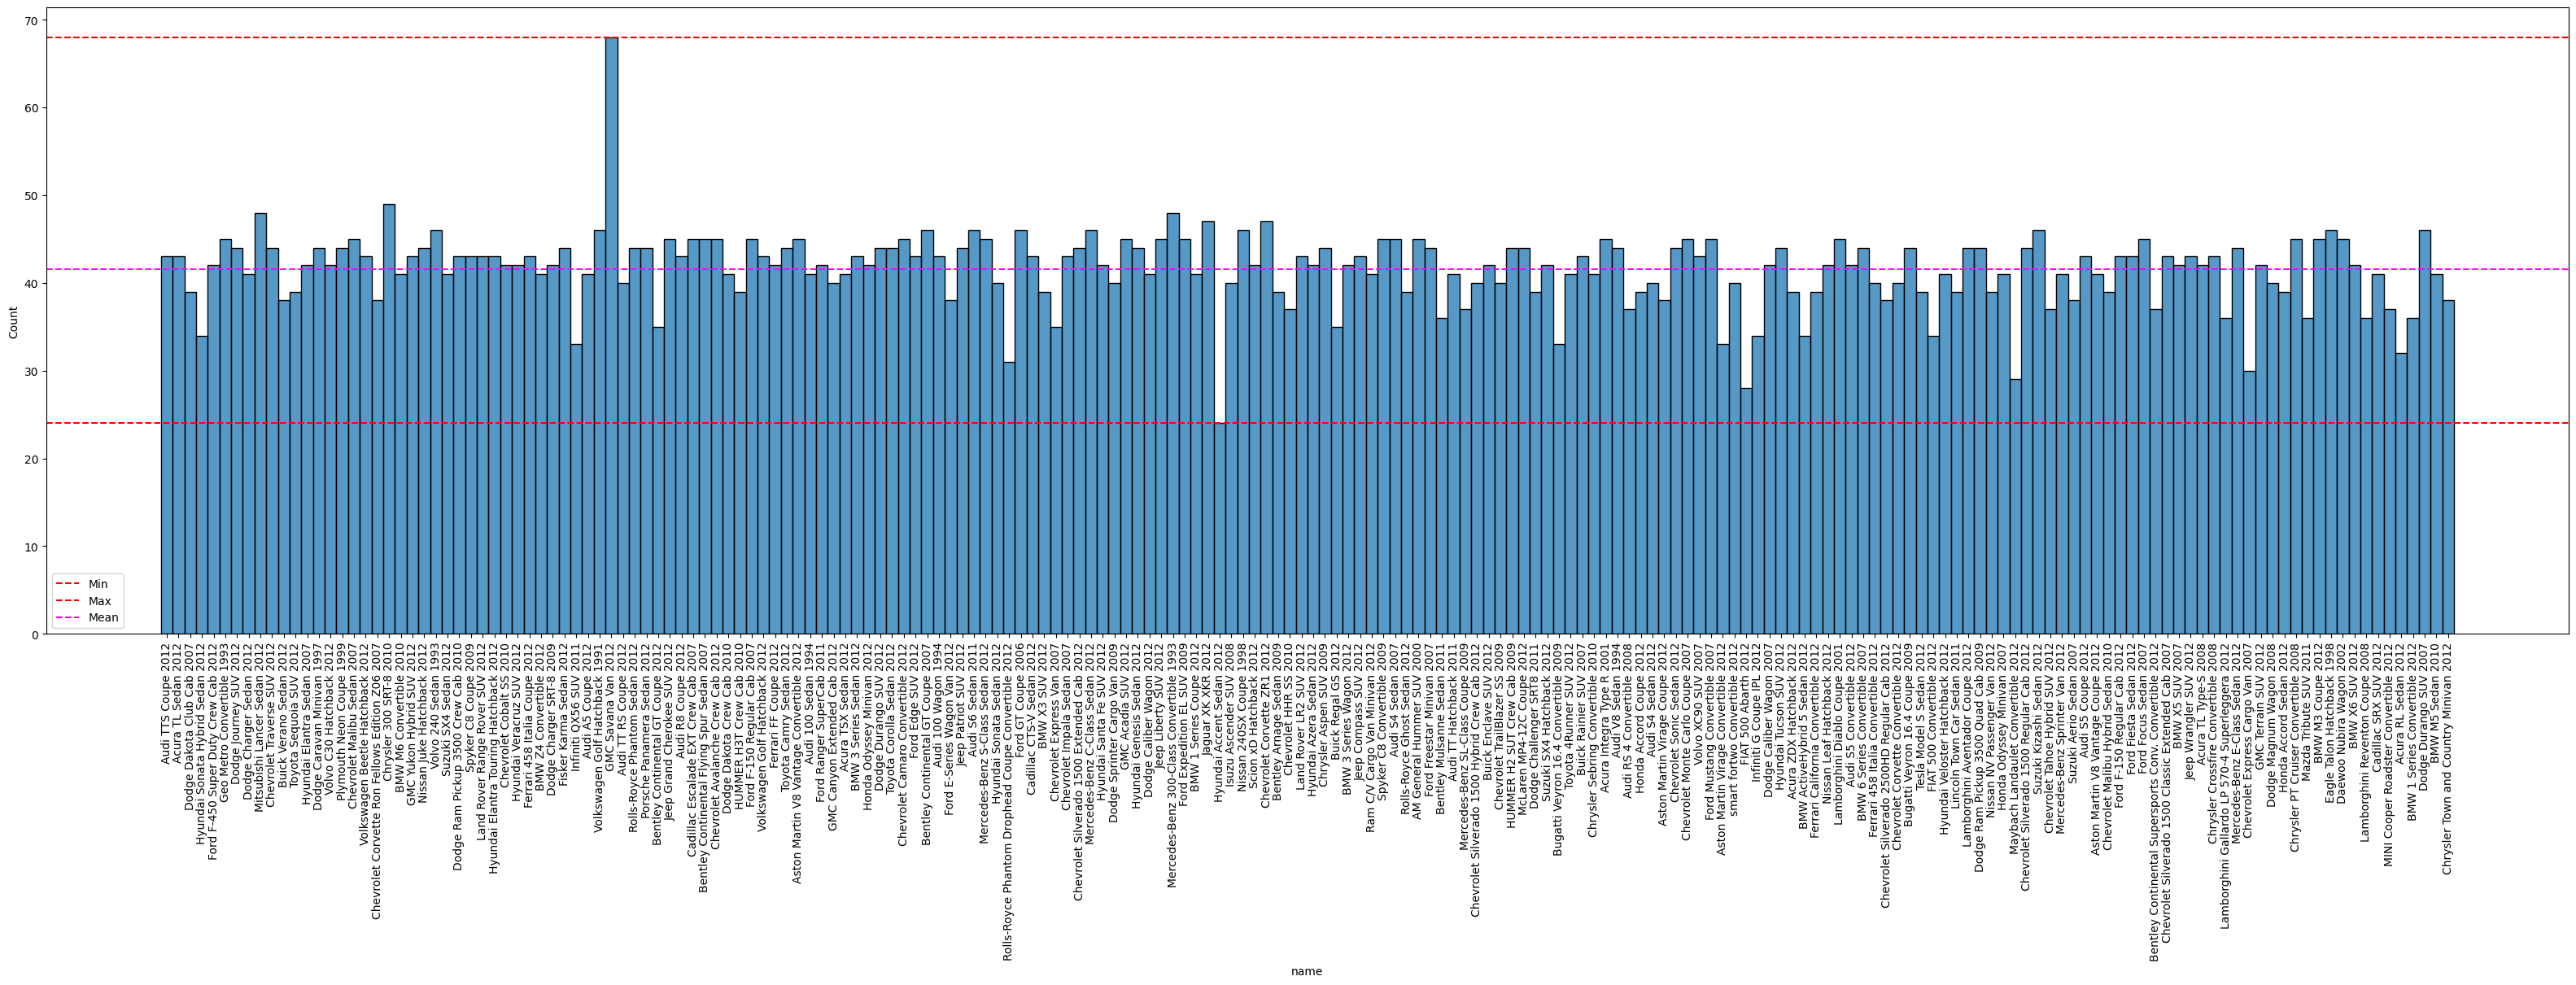

In [21]:
plot_class_count(train)

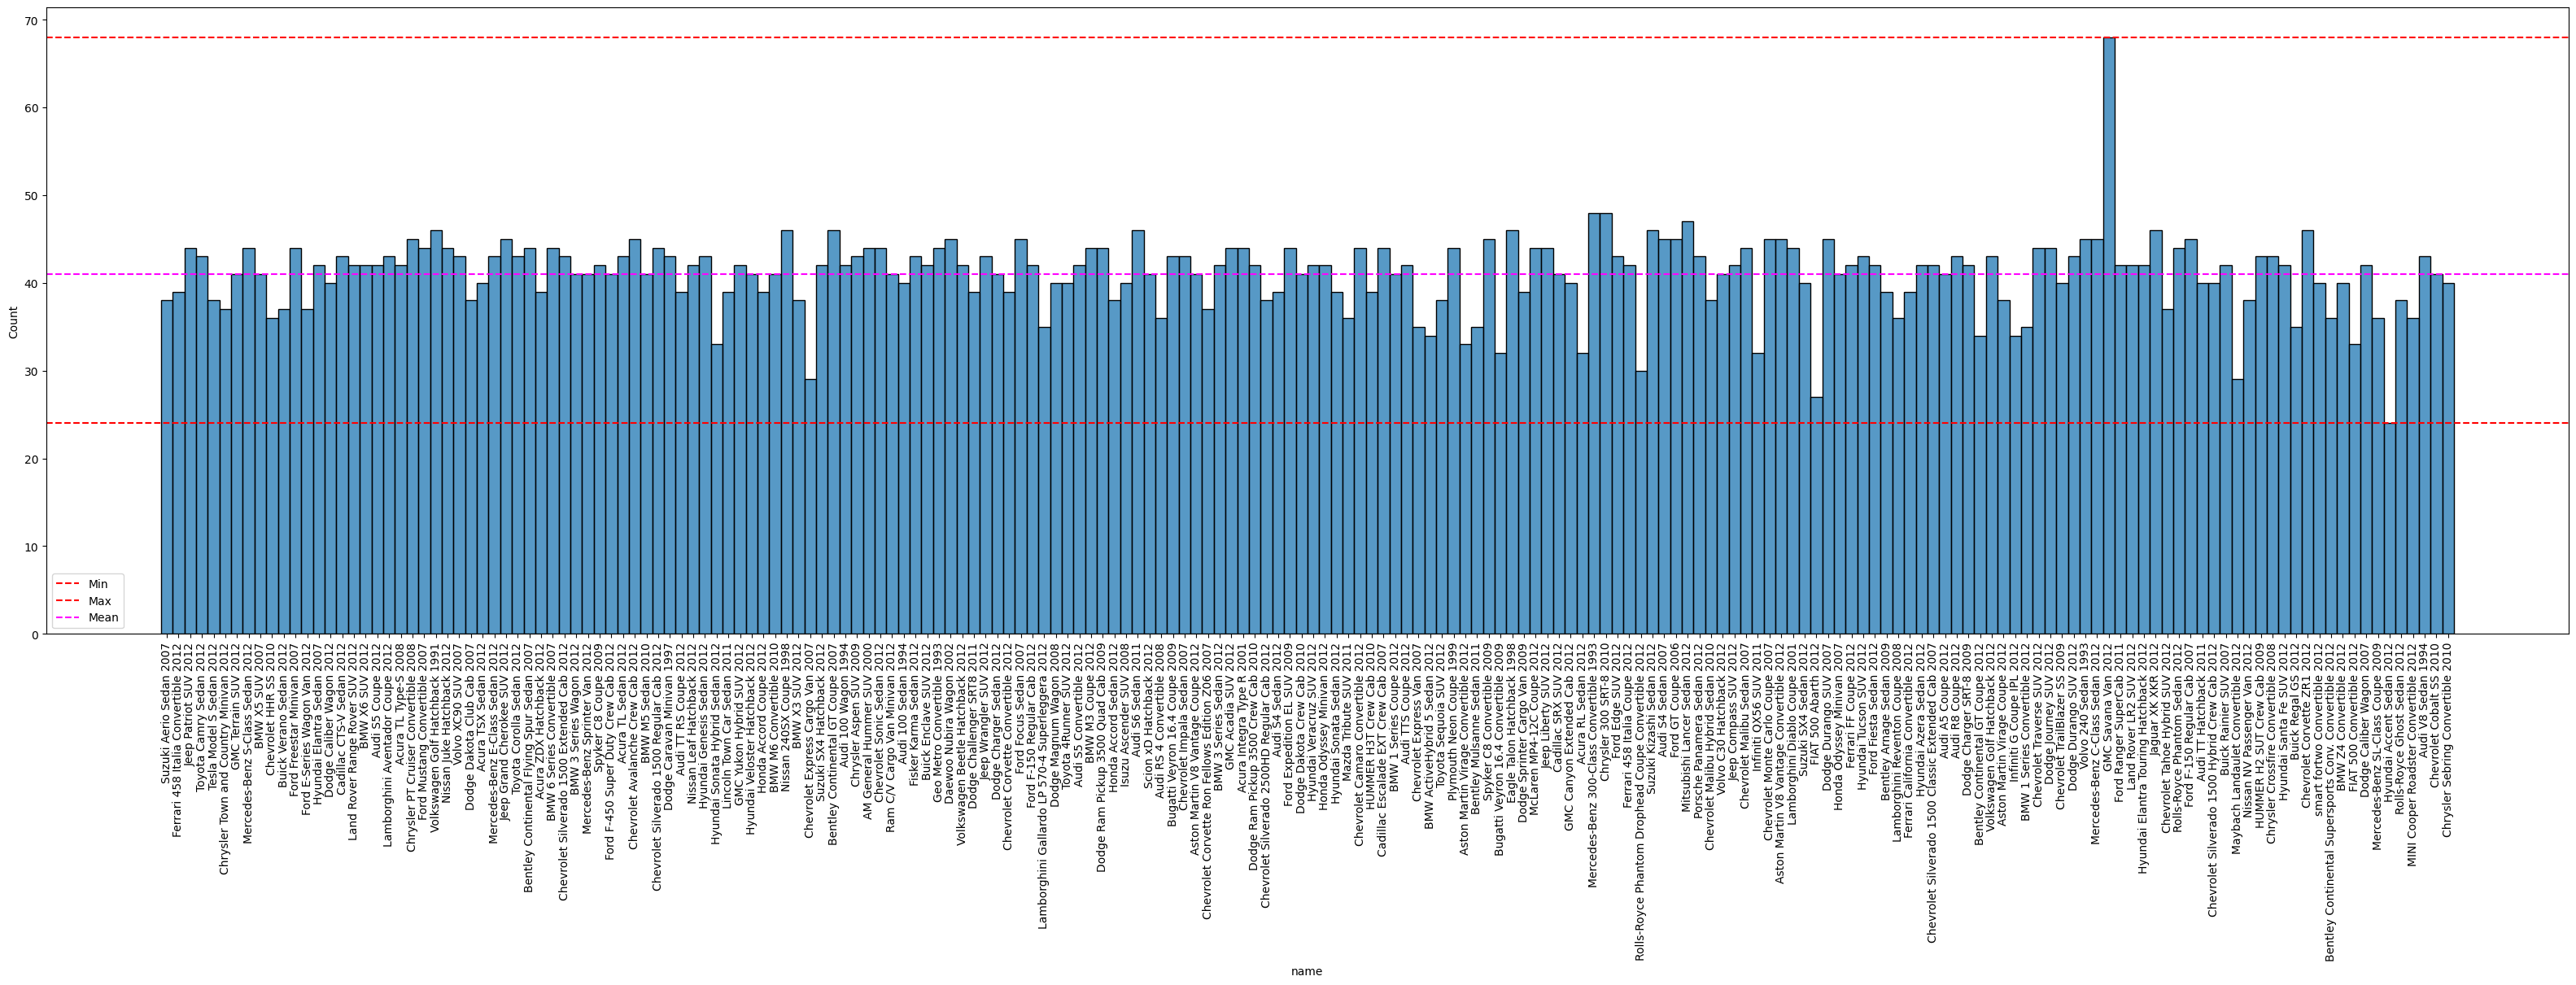

In [22]:
plot_class_count(test)

```
Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.
```

- aide à réduire la quantité de données nécessaires pour entraîner un model from scratch 
- aide à réduire les ressources de calcul nécessaires pour entraîner un model from scratch 
- aide à augmenter la capacité de généralisation, réduit rique d'overfitting
- peut permettre un apprentissage plus rapide

## Data Preprocessing and Data Augmentation

- Resizing images to size 400*400

- Normalizing pixel values to a range between 0 and 1

- Data Augmentation to improve the model generalization (rotation, flipping)

- Early Stopping to improve model efficiency and prevent overfitting

In [26]:
import torch # Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU not available, using CPU instead.
